In [14]:
%matplotlib inline

In [11]:
from linescanning import prf
import numpy as np
from scipy.stats import pearsonr
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from prfpy import stimulus
import yaml
from scipy import io
import matplotlib.patches as mpatches 
from matplotlib import gridspec

opd = os.path.dirname
opj = os.path.join

## <h1> Assessment of placebo and memantine DN model fits for the Memantine project </h1>
This notebook is used to assess different aspects of DN model pRF fits for placebo and memantine data separately. In the first part, I calculate correlation in the pRF center positions and assess differences in $R^2$-values between the fits. In the second part, I plot the distribution of $R^2$-values within each ROI for each subject individually. In the third part, I plot the fits and data of one specific vertex in both experimental conditions, as an illustration of the nature of the data. In the fourth part, I plot the relationship of eccentricity with full-width-at-half-max and full-width-at-minimum for the fits, as a sanity check.


In [4]:
conditions = {
    'sub-001': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-002': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-003': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-004': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-005': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-007': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-008': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-010': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-012': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-013': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-015': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-016': {'memantine': 'ses-2', 'placebo': 'ses-3'}
}

# define boundaries of fitting
minr2=0.1
minecc=0.5 #The minimum eccentricity you want to use
maxecc=4.5 #The maximum eccentricity you want to use
deriv='/data1/projects/Meman1/projects/pilot/derivatives'
model='norm'

# load some necessary files related to the pRF fitting
with open('/data1/projects/Meman1/projects/pilot/code/floris/prf_analysis.yml') as f:
    analysis_info = yaml.safe_load(f)

dm = io.loadmat(opj('/data1/projects/Meman1/projects/pilot/code', 'design_task-2R.mat'))['stim']

# define the pRF stimulus
prf_stim = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:40],
    TR=analysis_info['TR'])

ss = prf_stim.screen_size_degrees
max_ecc_size = ss/2.0

# define colors of the conditions for plotting purposes
placebo_patch = mpatches.Patch(color='royalblue', label='placebo')
memantine_patch = mpatches.Patch(color='firebrick', label='memantine')

In [5]:
# Define the bounds of the fits

norm_bounds = {'x':(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
               'y':(-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
               'prf_size': (0.2, 1.5*ss),  # prf size
               'A': (0,1000),  # prf amplitude
               'C': tuple(analysis_info['norm']['surround_amplitude_bound']),  # surround amplitude
               'surr_size': (0.1, 3*ss),  # surround size
               'B': tuple(analysis_info['norm']['neural_baseline_bound']),  # neural baseline
               'D': tuple([float(item) for item in analysis_info['norm']['surround_baseline_bound']])} # surround baseline

<h2>1. Calculate all parameters for DN fits in placebo and memantine condition</h2>

In [6]:
class Add_pRF_profile:
    # Class to do some filtering on a pRFmodelFitting object on Gaussian model. You mainly specify the eccentricities that you want to look at, your minimum r2, and potentially a ROI
    # It returns an object with most of the characteristics of the pRFmodelFitting, but also adds FWHM and FWMin
    
    def __init__(self,
                 pRFmodelFitting=None,
                 data=None,
                 design=None,
                 model=None,
                 stage=None,
                 params=None,
                 roi=None,
                 excludenegampl=False,
                 normalizeprofile=False,
                 eccmask=[minecc, maxecc],
                 r2mask=minr2):
        
        self.pRFmodelFitting=pRFmodelFitting
        if isinstance(self.pRFmodelFitting, prf.pRFmodelFitting):
            # if pRFmodelFitting object, get the necessary settings from here
            self.data=self.pRFmodelFitting.data
            self.model=self.pRFmodelFitting.model
            self.stage=self.pRFmodelFitting.stage
            self.params=prf.Parameters(params=getattr(self.pRFmodelFitting, f"{self.model}_{self.stage}"), model=self.model).to_df()
            self.design=self.pRFmodelFitting.design_matrix

        else:
            # else, take from manual input
            self.data=data
            self.model=model
            self.stage=stage
            self.params=params
            self.design=design
            
        # some additional settings
        self.excludenegampl=excludenegampl
        self.normalizeprofile=normalizeprofile
        self.eccmask=eccmask
        self.r2mask=r2mask
        self.roi=roi

        # select vertices based on roi...
        if self.roi is not None:
            try:
                self.params=self.params.loc[self.roi]
                print("ROI has", len(self.roi), "values")
            except:
                print("Not a valid ROI, give an array with vertex numbers for the ROI")
                print(len(self.roi))
                
        # drop vertices based on eccentricity and r2 boundaries
        self.params.loc[self.params['ecc'].values < self.eccmask[0]] = np.nan
        self.params.loc[self.params['ecc'].values > self.eccmask[1]] = np.nan
        self.params.loc[self.params['r2'].values < self.r2mask] = np.nan

        # drop vertices based on biological plausibility
        self.params.loc[self.params['surr_size'].values < self.params['prf_size'].values] = np.nan
        self.params.loc[self.params['prf_size'].values < 1.01*norm_bounds['prf_size'][0]] = np.nan

        print("Excluding", self.params.isna().any(axis=1).sum(), 'vertices based on mask...')
        self.params=self.params.dropna()

        # drop vertices if they have a negative pRF amplitude
        if self.excludenegampl:
            self.params.loc[self.params['prf_ampl'].values < 0] = np.nan
            print("Excluding", self.params.isna().any(axis=1).sum(), 'negative pRFs...')
            self.params=self.params.dropna()

        # initialize pRF profile profile characteristics
        self.x = np.linspace(-10,10,2000).astype('float32')
        self.profile_df = pd.DataFrame(index=self.params.index, columns=self.x)

        # function to calculate profile, FWHM, FWMin given an Add_pRF_profile object and a vertex index
        def profile_fwhm_fwmin(self, index):
            x = self.x
            params = self.params.loc[index]

            # calculate the activation pRF profile (and the volume underneath pRF)
            profile_act = params.prf_ampl * np.exp(-0.5*(x**2) / (params.prf_size**2))
            volume_act = np.sqrt(2*np.pi*(params.prf_size**2)) # NOT USED NOW, CAN BE USED LATER!!

            if self.model=='gauss':
                # calculate halfmax and fwhmax
                half_max = np.max(profile_act, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile_act-half_max), axis=0)])

                return fwhmax, half_max
            
            elif self.model=='norm':
                # calculate the normalization pRF profule (and the volume underneath pRF)
                profile_norm = params.surr_ampl * np.exp(-0.5*(x**2) / (params.surr_size**2))
                volume_norm = np.sqrt(2*np.pi*(params.surr_size**2)) # NOT USED NOW, CAN BE USED LATER!!

                # calculate full profile based on constants, profile act, and profile norm
                profile = (profile_act + params.B)/(profile_norm + params.D) - (params.B/params.D)
                
                # normalize RFs if necessary
                if self.normalizeprofile:
                    profile /= np.max(profile)

                # calculate halfmax and fwhmax
                half_max = np.max(profile, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

                minim = np.min(profile, axis=0)
                maxim = np.max(profile, axis=0)

                fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

                # if fwmin is this large, it does not make any sense really as there is no visible surround. leaving it in would create an outlier    
                if fwmin==float(20.0):
                    fwmin=np.nan
                
                if minim>0 or maxim<0.01 or profile[999]<maxim:
                    fwhmax=np.nan
                    half_max=np.nan
                    minim=np.nan
                    maxim=np.nan
                    fwmin=np.nan
                    
                return fwhmax, half_max, minim, maxim, fwmin

        # now, add the profile measures to the dataframe
        if self.model=='gauss':
            for vert in self.params.index:
                fwhmaxx, half_maxx = profile_fwhm_fwmin(self, vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx

        elif self.model=='norm':
            for vert in self.params.index:
                fwhmaxx, half_maxx, minimm, maximm, fwminn = profile_fwhm_fwmin(self, vert)
                if abs(minimm)/maximm == np.inf:
                    print(vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx
                self.params.loc[vert, 'minimum'] = minimm
                self.params.loc[vert, 'maximum'] = maximm
                self.params.loc[vert, 'min/max'] = minimm/maximm
                self.params.loc[vert, 'fwmin'] = fwminn
                self.params.loc[vert, 'basetopeak']= np.abs(maximm-minimm)

In [7]:
# Here, I will store all output after looping over the subjects
prffits = {
    sub: {
        'fits': {'placebo': None, 'memantine': None},
        'roi_vertices': {'V1_vertices': None, 'V2_vertices': None, 'V3_vertices': None}
    } for sub in ['sub-001','sub-002','sub-003','sub-004','sub-005','sub-007','sub-008','sub-010','sub-012','sub-013','sub-015','sub-016']}

Now, loop over all the subjects:

In [8]:
for sub in conditions.keys():
    print(f"Working on subject {sub}...")
    print("")

    #######################################################
    ###### LOADING IN ROIs ################
    #######################################################

    print("Getting ROI vertices...")
    print("")

    finalrois= opj(deriv, 'freesurfer',sub, 'customlabel', 'roidrawing', 'final')
    
    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

    all_lh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'lh.inflated'))

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

    all_rh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    # Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    roi_vertices = np.sort(np.concatenate([V1_vertices, V2_vertices, V3_vertices]))

    prffits[sub]['roi_vertices']['V1_vertices'] = V1_vertices
    prffits[sub]['roi_vertices']['V2_vertices'] = V2_vertices
    prffits[sub]['roi_vertices']['V3_vertices'] = V3_vertices

    for condition in ['placebo', 'memantine']:
        print(f"Working on {condition}...")
        print("")

        # First, get path to the appropriate files
        design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))
        outputdata = opj('/data1/projects/Meman1/projects/pilot/code/floris/output', sub)

        # Load data
        data = np.load(opj(deriv, 'prf', sub, conditions[sub][condition], f'{sub}_{conditions[sub][condition]}_task-2R_hemi-LR_desc-avg_bold.npy'))

        # Initialize empty array of parameters with the appropriate shape
        params_norm = np.zeros(shape=(data.shape[1], 12))

        #######################################################
        ###### GETTING ALL PARAMETERS IN RIGHT SPOT ###########
        #######################################################

        print("Putting parameters in right place...")
        print("")

        for i in range(20):
            roivertices = np.load(opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy'))
            paramss= np.load(opj(outputdata, 'fits', f'{sub}_{conditions[sub][condition]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy'))

            for index, roivertex in enumerate(roivertices):
                params_norm[roivertex] = paramss[index]

        #######################################################
        ###### LOADING IN PARAMETERS IN OBJECT ################
        #######################################################
        print("Creating pRFmodelFitting object...")
        print("")
        
        # initialize empty model
        norm_obj= prf.pRFmodelFitting(
            data.T,
            design_matrix=design,
            TR=1.5,                     # default
            model=model,                # default, can be 'gauss', 'css', 'dog', 'norm'
            stage="iter",               # default
            verbose=True,               # keep track of what we're doing,
            fix_bold_baseline=True      # fix the BOLD baseline at 0
        )

        # load params
        norm_obj.load_params(params_norm, model=model, stage="iter")

        #######################################################
        ###### CREATING AN ADD_PRF_PROFILE OBJ ################
        #######################################################
        print("Creating an Add_pRF_profile...")
        print("")

        norm_filtered = Add_pRF_profile(norm_obj, r2mask=0.1, eccmask=[0.5, 4.5], roi=roi_vertices) # You can change things here in the settings if you want

        #######################################################
        ###### ADDING TO DICTIONARY NOW     ###################
        #######################################################

        prffits[sub]['fits'][condition] = norm_filtered

Working on subject sub-001...

Getting ROI vertices...

Working on placebo...

Putting parameters in right place...

Creating pRFmodelFitting object...

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f12ee6934c0>
Creating an Add_pRF_profile...

ROI has 4374 values
Excluding 554 vertices based on mask...
Working on memantine...

Putting parameters in right p

First, dryly compare the x-, y-, and $R^2$ values for the different sessions. I put all ROIs together here.

In [20]:
basic_params_list_df = []

for sub in conditions.keys():
    # select vertices based on if the fit for the vertex was done both for placebo and memantine condition and if the R2 exceeds 0.3 in at least one of the conditions
    valid_vertices = [vertex for vertex in prffits[sub]['fits']['placebo'].params.index if vertex in prffits[sub]['fits']['memantine'].params.index 
                      and (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 or 
                            prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]

    # now, select parameters
    params_placebo_valid = prffits[sub]['fits']['placebo'].params.loc[valid_vertices][['x', 'y', 'r2']]
    params_memantine_valid = prffits[sub]['fits']['memantine'].params.loc[valid_vertices][['x', 'y', 'r2']]

    datasub = pd.merge(params_placebo_valid, params_memantine_valid, left_index=True, right_index=True, suffixes=['_placebo','_memantine'])
    datasub['sub'] = sub

    basic_params_list_df.append(datasub)

basic_params_collection = pd.concat(basic_params_list_df, ignore_index=True)

Calculate correlation coefficient for X, Y, and R2

In [21]:
corrcoef_x = pearsonr(basic_params_collection['x_placebo'].values, basic_params_collection['x_memantine'].values)
corrcoef_y = pearsonr(basic_params_collection['y_placebo'].values, basic_params_collection['y_memantine'].values)
corrcoef_r2 = pearsonr(basic_params_collection['r2_placebo'].values, basic_params_collection['r2_memantine'].values)

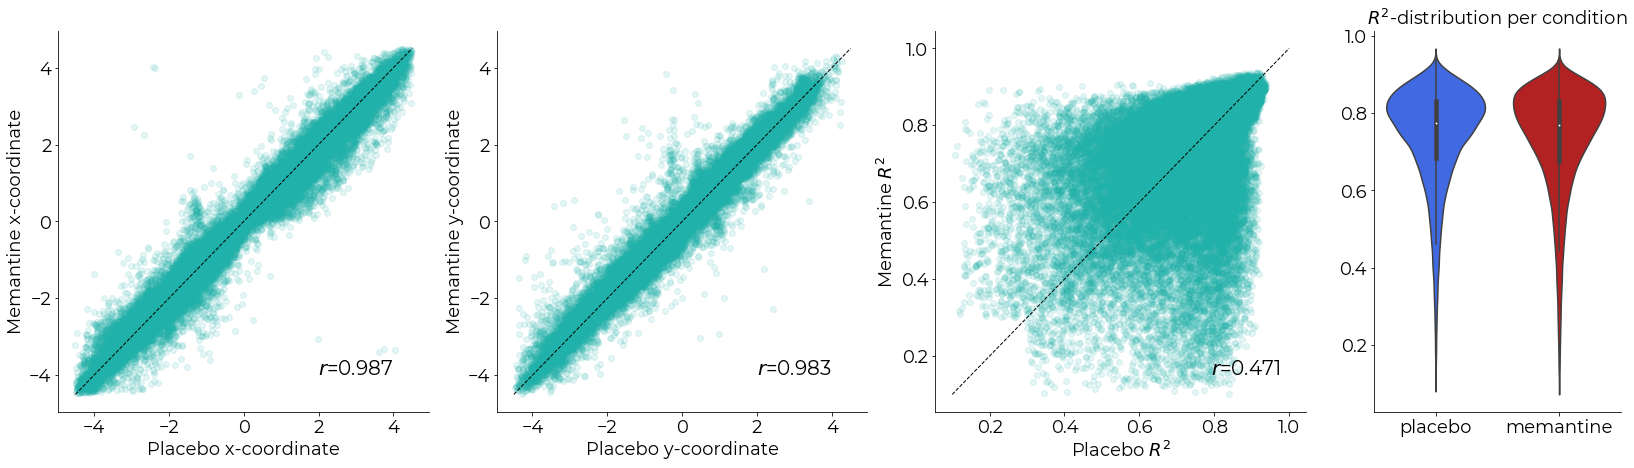

In [22]:
fig = plt.figure(figsize=(28,7))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

main_gs = gridspec.GridSpec(1, 4, width_ratios=[3,3,3,2])  # Define a 1-row, 2-column layout with width ratio 2:1

ax1 = fig.add_subplot(main_gs[0])  # First subplot with a width ratio of 2
ax2 = fig.add_subplot(main_gs[1])
ax3 = fig.add_subplot(main_gs[2])
ax4 = fig.add_subplot(main_gs[3])

ax1.scatter(basic_params_collection['x_placebo'].values, basic_params_collection['x_memantine'].values, alpha = 0.12, color='lightseagreen')
ax1.set_xlabel("Placebo x-coordinate", fontsize=18)
ax1.set_ylabel("Memantine x-coordinate", fontsize=18)
ax1.plot(np.linspace(-4.5,4.5,1000), np.linspace(-4.5,4.5,1000), linestyle='--', color='black', linewidth=1)
ax1.text(3,-4, f"$r$={round(corrcoef_x.statistic, 3)}", horizontalalignment='center', fontsize=20)

ax2.scatter(basic_params_collection['y_placebo'].values, basic_params_collection['y_memantine'].values, alpha = 0.12,color='lightseagreen')
ax2.set_xlabel("Placebo y-coordinate", fontsize=18)
ax2.set_ylabel("Memantine y-coordinate", fontsize=18)
ax2.plot(np.linspace(-4.5,4.5,1000), np.linspace(-4.5,4.5,1000), linestyle='--', color='black', linewidth=1)
ax2.text(3,-4, f"$r$={round(corrcoef_y.statistic, 3)}", horizontalalignment='center', fontsize=20)

ax3.scatter(basic_params_collection['r2_placebo'].values, basic_params_collection['r2_memantine'].values, alpha = 0.12,color='lightseagreen')
ax3.set_xlabel("Placebo $R^2$", fontsize=18)
ax3.set_ylabel("Memantine $R^2$", fontsize=18)
ax3.plot(np.linspace(0.1,1,1000), np.linspace(0.1,1,1000), linestyle='--', color='black', linewidth=1)
ax3.text(0.883, 0.15, f"$r$={round(corrcoef_r2.statistic, 3)}", horizontalalignment='center', fontsize=20)

# Violin plot
sns.violinplot(data=basic_params_collection[['r2_placebo', 'r2_memantine']], ax=ax4, palette={'r2_placebo': 'royalblue', 'r2_memantine': 'firebrick'}, saturation=1)
ax4.set_xticklabels(['placebo', 'memantine'])
ax4.set_title("$R^2$-distribution per condition", fontsize=18)

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/PlacvsMem_scatter.png"
sns.despine()

plt.savefig(save_path, dpi=300)

plt.show()

In [24]:
print("For", len(basic_params_collection['r2_placebo']), "vertices in placebo condition", "Mean R2 = ", basic_params_collection['r2_placebo'].mean(), "SD = ", basic_params_collection['r2_placebo'].std())
print("For", len(basic_params_collection['r2_memantine']), "vertices in memantine condition", "Mean R2 = ", basic_params_collection['r2_memantine'].mean(), "SD = ", basic_params_collection['r2_memantine'].std())

For 67276 vertices in placebo condition Mean R2 =  0.7400860676987068 SD =  0.13022686713551473
For 67276 vertices in memantine condition Mean R2 =  0.733886029130263 SD =  0.1384469251132031


<h2> 2. Plot the R2-distributions of the fits per subject </h2>

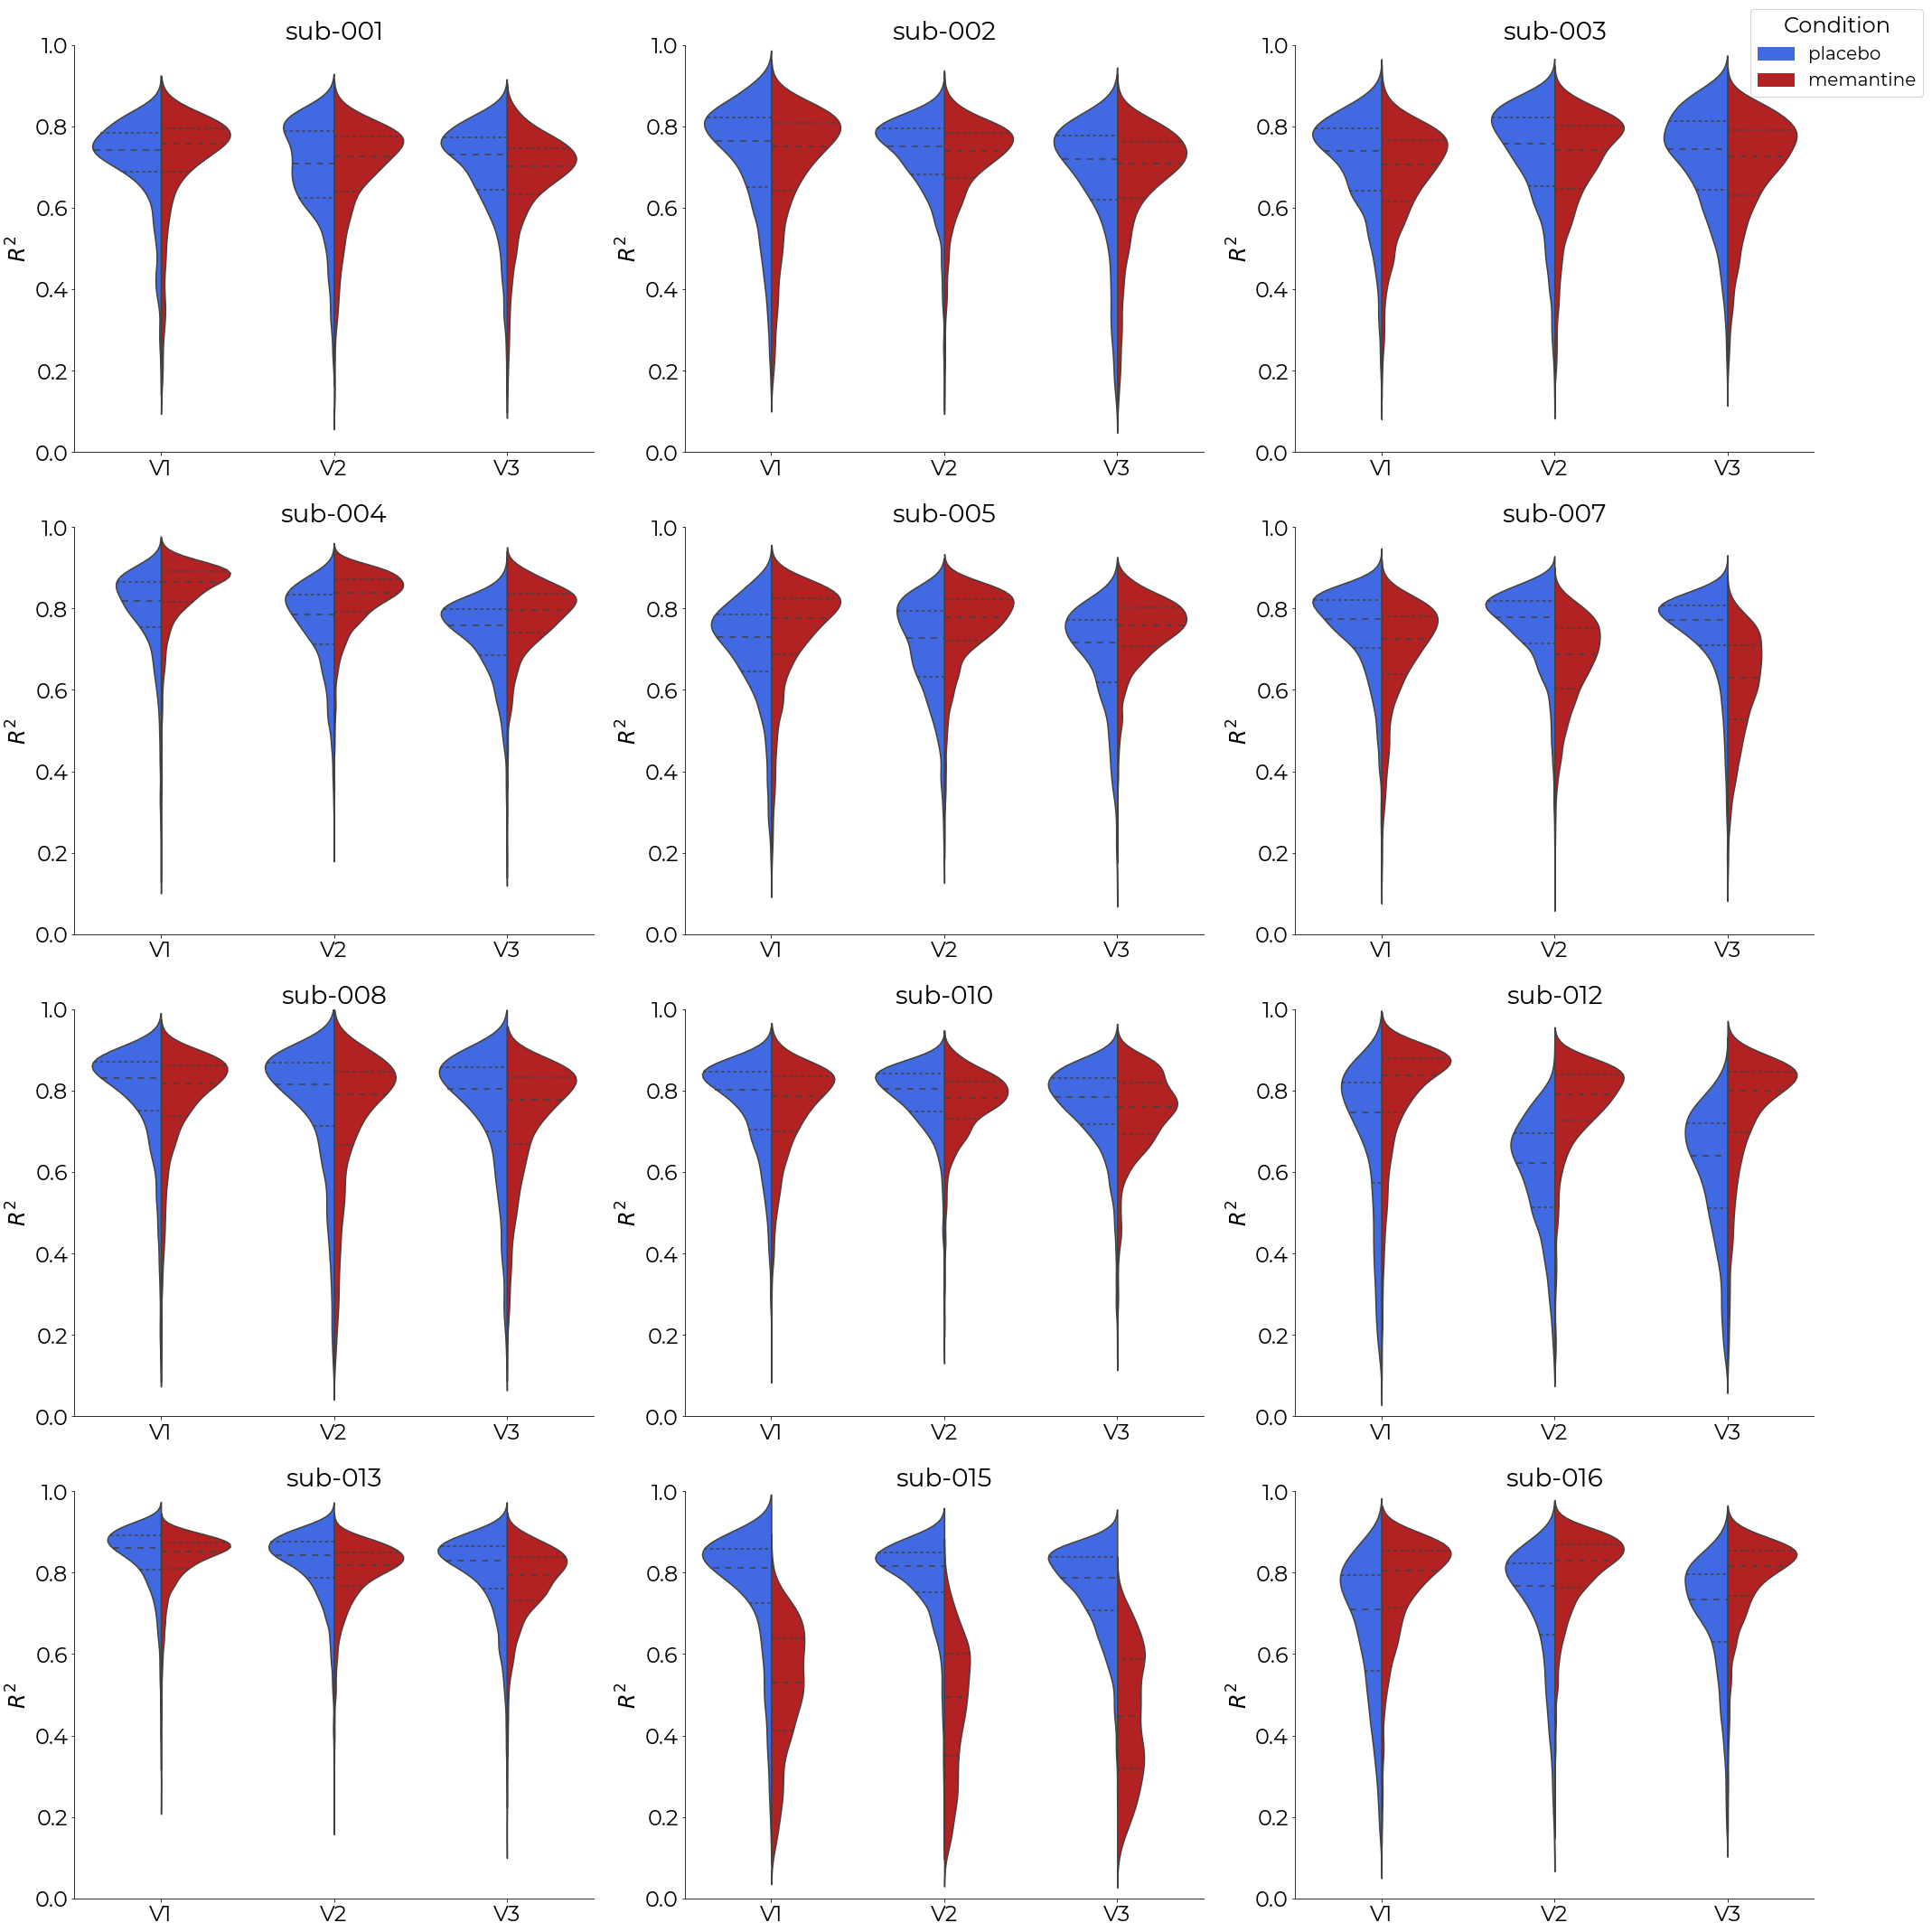

In [26]:
fig, axes = plt.subplots(4,3, figsize=(30, 30))
plt.rcParams.update({'font.size': 24})

for index, sub in enumerate(conditions.keys()):
    ax = axes[index//3, index%3]
    rois = ['V1','V2','V3']
    dfs=[]

    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V2_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V2_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V2_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V2_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V3_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V3_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V3_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V3_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    loopdict = {'V1':{'placebo': valid_vertices_V1_plac, 'memantine':valid_vertices_V1_mem}, 'V2':{'placebo': valid_vertices_V2_plac, 'memantine':valid_vertices_V2_mem}, 'V3':{'placebo': valid_vertices_V3_plac, 'memantine':valid_vertices_V3_mem}}
    
    # loop over the individual ROIs and extract the R2 for the vertices
    for roi in ['V1','V2','V3']:
        for condition in ['placebo','memantine']:
            valid_verts = loopdict[roi][condition]

            df_temp = prffits[sub]['fits'][condition].params.loc[valid_verts][['r2']]
            df_temp['sub'] = sub
            df_temp['roi'] = roi
            df_temp['condition'] = condition
            dfs.append(df_temp.reset_index(drop=True))

    # Concatenate all the dataframes
    result_df = pd.concat(dfs, ignore_index=True)
    sns.violinplot(data=result_df, x='roi',y='r2',hue='condition', split=True, palette={'placebo':'royalblue','memantine':'firebrick'}, inner='quart', ax=ax, saturation=1)
    ax.set_title(sub, fontsize=28)
    ax.set_ylim(0,1)
    ax.legend_.remove()
    ax.set_ylabel('$R^2$')
    ax.set_xlabel('')

sns.despine()

# Create one legend outside the subplots
fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right',title='Condition', fontsize=20)

# Adjust layout to make space for the legend
fig.tight_layout(rect=[0, 0, 0.95, 1])

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/R2_allsubjects.png"
plt.savefig(save_path, dpi=300)

plt.show()

<h2> 3. Plot placebo and memantine fits of representative vertex in V1 </h2>

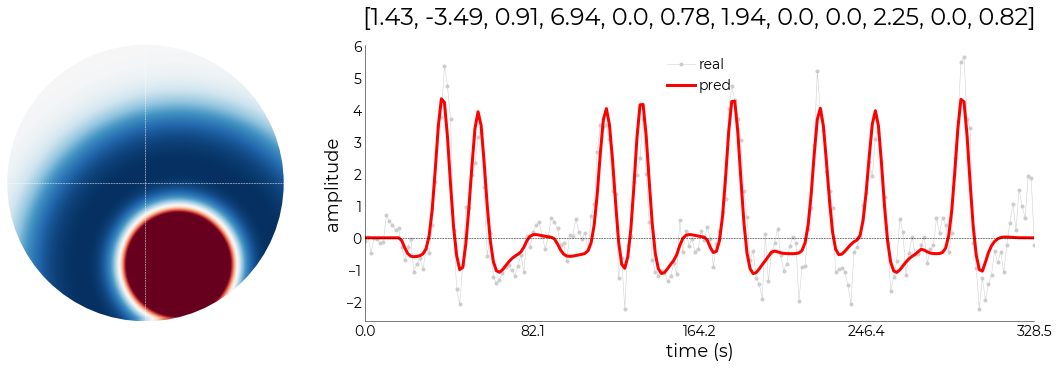

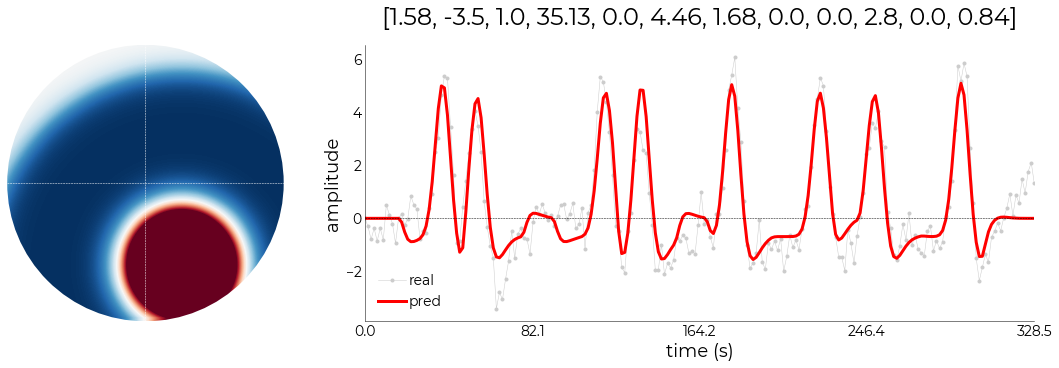

In [32]:
norm_plac = prffits['sub-013']['fits']['placebo'].pRFmodelFitting
norm_mem = prffits['sub-013']['fits']['memantine'].pRFmodelFitting

_, _, _, prednormplac, = norm_plac.plot_vox(vox_nr=19, title="pars", model='norm')
_, _, _, prednormmem, = norm_mem.plot_vox(vox_nr=19, title="pars", model='norm')

dataplacebo = norm_plac.data
datamemantine = norm_mem.data

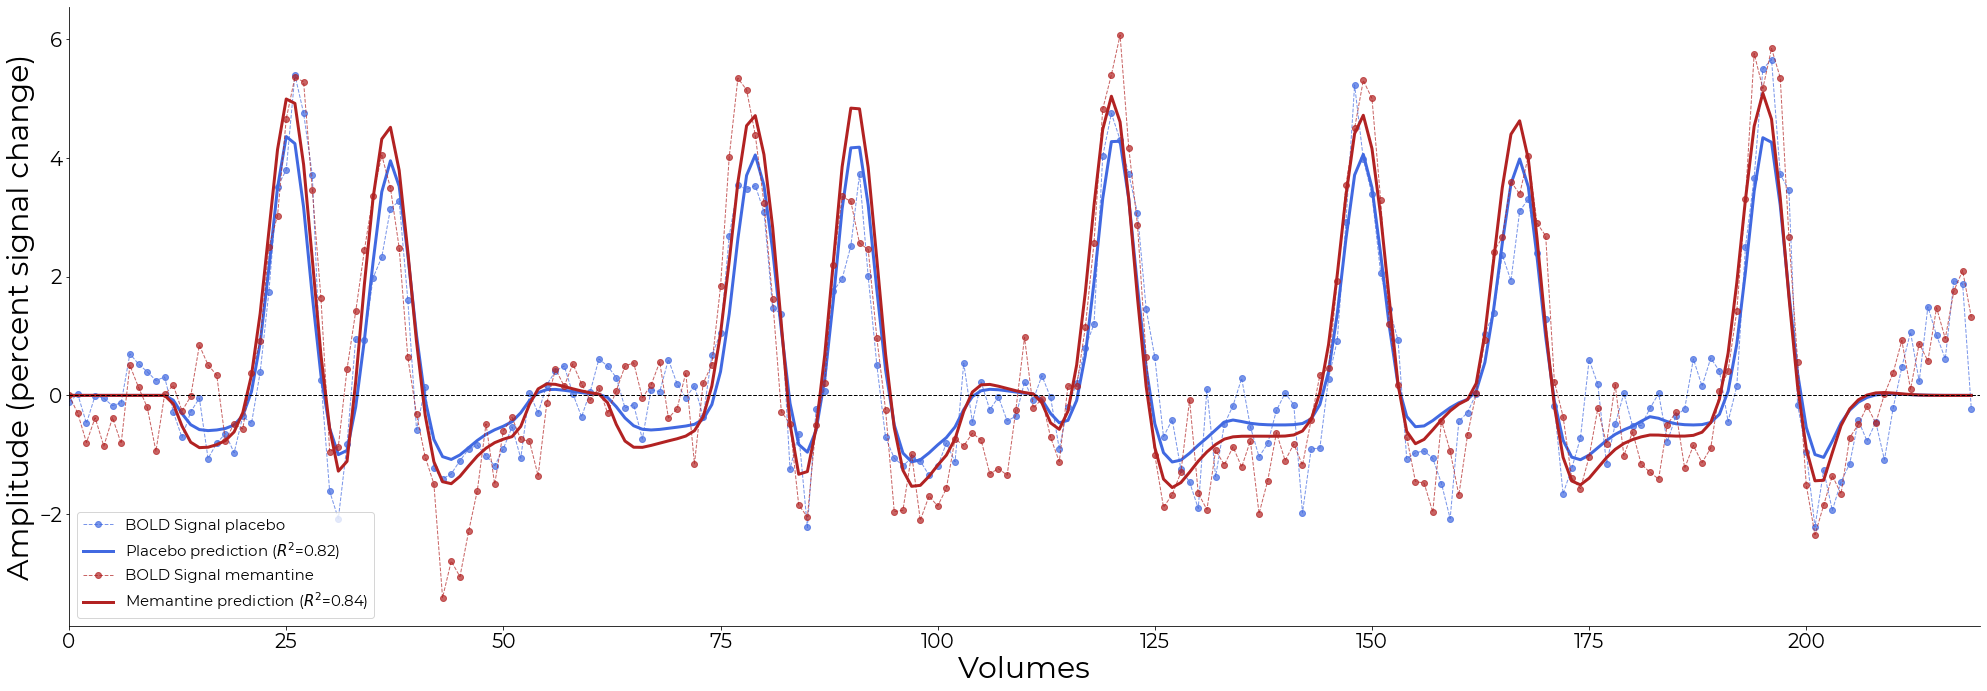

In [34]:
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 20})

# Create the plot
plt.figure(figsize=(28, 10))  # Convert width from cm to inches

# Plot the actual BOLD signal
plt.plot(dataplacebo[19, :], 'o-', color='royalblue', linewidth=1, linestyle='--', label='BOLD Signal placebo', alpha=0.7)
plt.plot(prednormplac, '-', color='royalblue', linewidth=3, label='Placebo prediction ($R^2$=0.82)')

plt.plot(datamemantine[19, :], 'o-', color='firebrick', linewidth=1, linestyle='--', label='BOLD Signal memantine', alpha=0.7)
plt.plot(prednormmem, '-', color='firebrick', linewidth=3, label='Memantine prediction ($R^2$=0.84)')

# Plot the predictions

# Add labels and legend
plt.xlabel('Volumes', fontsize=30)
plt.ylabel('Amplitude (percent signal change)', fontsize=30)
plt.hlines(0, xmin=0, xmax=220, color='black',linestyle='--', linewidth=1)
plt.xlim(0, 220)
plt.tight_layout()
sns.despine()
plt.legend(fontsize=15,loc='best')

savepath = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/plac_mem_timecourse.png"
plt.savefig(savepath, dpi=300)

# Show the plot
plt.show()

<h2> Plot FWHM and FWMin in both conditions and all ROIs </h2>

In [27]:
def filter_prffits_roi(prffits, sub, condition, roi, type):

    if type=="params": # IT IS ALSO EASY TO DO THIS WITH GETATTR, MAYBE BETTER
        params = prffits[sub]['fits'][condition].params
    
    if type=="profile_df": # IT IS ALSO EASY TO DO THIS WITH GETATTR, MAYBE BETTER
        params = prffits[sub]['fits'][condition].profile_df

    else:
        "MISSING TYPE"
    
    if roi in ['V1_vertices', 'V2_vertices', 'V3_vertices']:
        roivertices = prffits[sub]['roi_vertices'][roi]
        valid_vertices = sorted(list(set(params.index).intersection(set(roivertices))))
        
        return params.loc[valid_vertices]
    
    else:
        print(f"returning full params for {sub} and {condition}")
        return params

In [28]:
grouped_parameters = {
                    'V1V2V3_vertices': pd.DataFrame(columns=["sub","condition", "vertex_nr", "prf_size","surr_size","A","B","C","D","ratio (B/D)","suppression index","fwhm", "fwmin","basetopeak", "minimum", "maximum", "size ratio","ecc","r2"]),
                    'V1_vertices': pd.DataFrame(columns=["sub","condition", "vertex_nr","prf_size","surr_size","A","B","C","D","ratio (B/D)","suppression index","fwhm", "fwmin","basetopeak","minimum", "maximum","size ratio","ecc","r2"]), 
                    'V2_vertices': pd.DataFrame(columns=["sub","condition", "vertex_nr","prf_size","surr_size","A","B","C","D","ratio (B/D)","suppression index","fwhm", "fwmin","basetopeak","minimum", "maximum","size ratio","ecc","r2"]), 
                    'V3_vertices': pd.DataFrame(columns=["sub","condition", "vertex_nr","prf_size","surr_size","A","B","C","D","ratio (B/D)","suppression index","fwhm", "fwmin","basetopeak", "minimum","maximum","size ratio","ecc","r2"])
                    }

dfs = {'V1V2V3_vertices': [], 'V1_vertices': [], 'V2_vertices': [], 'V3_vertices': []}

for roi in dfs.keys():
    print("Working on", roi)

    for sub in conditions.keys():
        print("Working on", sub)

        for condition in ['placebo', 'memantine']:
            print("Working on", condition)

            filtered_params_roi = filter_prffits_roi(prffits, sub, condition, roi, 'params')
            filtered_params_roi['sub']=sub
            filtered_params_roi['condition']=condition
            filtered_params_roi['vertex_nr']=filtered_params_roi.index

            filtered_params_roi = filtered_params_roi[['sub','condition','vertex_nr', "prf_size","surr_size","A","B","C","D","ratio (B/D)","suppression index","fwhm", "fwmin","basetopeak", "minimum","maximum","size ratio","ecc","r2"]]
            
            print("Concatenating...")
            dfs[roi].append(filtered_params_roi)
            print("")
    
    grouped_parameters[roi] = pd.concat(dfs[roi], ignore_index=True)

Working on V1V2V3_vertices
Working on sub-001
Working on placebo
returning full params for sub-001 and placebo
Concatenating...

Working on memantine
returning full params for sub-001 and memantine
Concatenating...

Working on sub-002
Working on placebo
returning full params for sub-002 and placebo
Concatenating...

Working on memantine
returning full params for sub-002 and memantine
Concatenating...

Working on sub-003
Working on placebo
returning full params for sub-003 and placebo
Concatenating...

Working on memantine
returning full params for sub-003 and memantine
Concatenating...

Working on sub-004
Working on placebo
returning full params for sub-004 and placebo
Concatenating...

Working on memantine
returning full params for sub-004 and memantine
Concatenating...

Working on sub-005
Working on placebo
returning full params for sub-005 and placebo
Concatenating...

Working on memantine
returning full params for sub-005 and memantine
Concatenating...

Working on sub-007
Working o

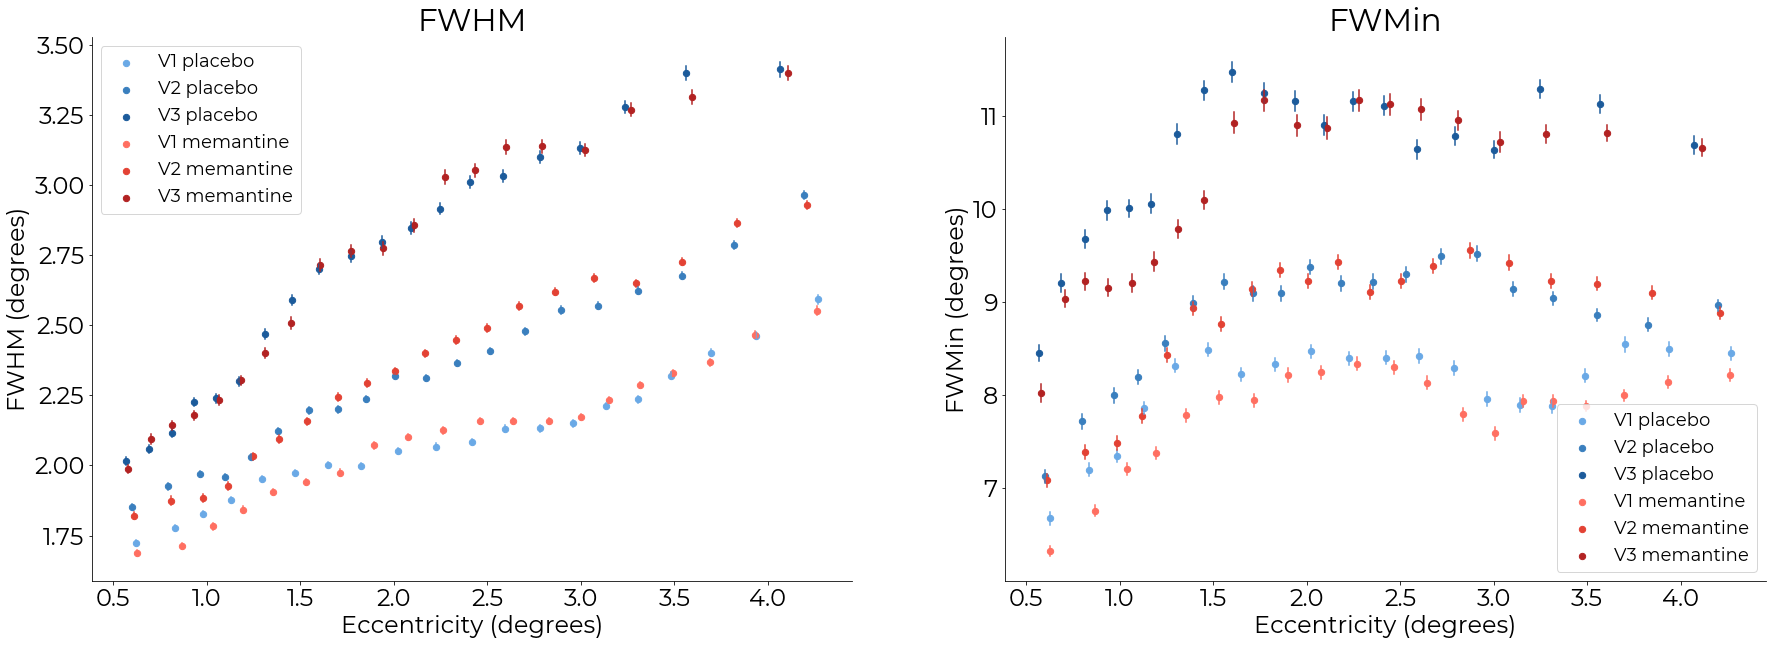

In [29]:
colorlist = [
    ['royalblue', '#6aa9e6', '#3a7fbe', '#1c5b9b'],  # Shades of blue for placebo (V1, V2, V3)
    ['firebrick', '#ff6f61', '#e34234', '#b22222']  ]  # Shades of red for memantine (V1, V2, V3)

titledict = {'fwhm': 'FWHM', 'fwmin': 'FWMin', 'prf_size': 'Activation pRF size', 'surr_size': 'Normalization pRF size', 'suppression index': 'Suppression index'}

fig, ax = plt.subplots(1,2,figsize=(30,10))

plt.rcParams.update({'font.size': 26})
for jndex, metric in enumerate(['fwhm', 'fwmin']):
    axs = ax[jndex]


    for index, condition in enumerate(['placebo', 'memantine']):

        num_bins=20
        bin_edges = np.linspace(0.5,4.5, num_bins+1)
    
        shapemetrics_V1 = grouped_parameters['V1_vertices'][grouped_parameters['V1_vertices']['condition'] == condition].dropna(subset=metric)
        shapemetrics_V2 = grouped_parameters['V2_vertices'][grouped_parameters['V2_vertices']['condition'] == condition].dropna(subset=metric)
        shapemetrics_V3 = grouped_parameters['V3_vertices'][grouped_parameters['V3_vertices']['condition'] == condition].dropna(subset=metric)

        # Calculate eccentricity bins for each ROI
        shapemetrics_V1['eccentricity_bin'] = pd.qcut(shapemetrics_V1['ecc'], q=num_bins)
        shapemetrics_V2['eccentricity_bin'] = pd.qcut(shapemetrics_V2['ecc'], q=num_bins)
        shapemetrics_V3['eccentricity_bin'] = pd.qcut(shapemetrics_V3['ecc'], q=num_bins)

        # Calculate SEM for each group
        sem_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x['ecc']) / np.sqrt(len(x['ecc'])))
        sem_fwhm_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

        sem_ecc_v2 = shapemetrics_V2.groupby('eccentricity_bin').apply(lambda x: np.std(x['ecc']) / np.sqrt(len(x['ecc'])))
        sem_fwhm_v2 = shapemetrics_V2.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

        sem_ecc_v3 = shapemetrics_V3.groupby('eccentricity_bin').apply(lambda x: np.std(x['ecc']) / np.sqrt(len(x['ecc'])))
        sem_fwhm_v3 = shapemetrics_V3.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

        # Calculate mean for each group
        df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.average(x['ecc'], weights=x['r2']))
        df_mean_fwhm_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.average(x[metric], weights=x['r2']))

        df_mean_ecc_v2 = shapemetrics_V2.groupby('eccentricity_bin').apply(lambda x: np.average(x['ecc'], weights=x['r2']))
        df_mean_fwhm_v2 = shapemetrics_V2.groupby('eccentricity_bin').apply(lambda x: np.average(x[metric], weights=x['r2']))

        df_mean_ecc_v3 = shapemetrics_V3.groupby('eccentricity_bin').apply(lambda x: np.average(x['ecc'], weights=x['r2']))
        df_mean_fwhm_v3 = shapemetrics_V3.groupby('eccentricity_bin').apply(lambda x: np.average(x[metric], weights=x['r2']))

        # Plot scatter plot
        axs.scatter(df_mean_ecc_v1.values, df_mean_fwhm_v1.values, color=colorlist[index][1], label=f'V1 {condition}', s=40)

        axs.scatter(df_mean_ecc_v2.values, df_mean_fwhm_v2.values, color=colorlist[index][2], label=f'V2 {condition}', s=40)

        axs.scatter(df_mean_ecc_v3.values, df_mean_fwhm_v3.values, color=colorlist[index][3], label=f'V3 {condition}', s=40)

        # Plot vertical lines for SEM
        for x, y, sem in zip(df_mean_ecc_v1.values, df_mean_fwhm_v1.values, sem_fwhm_v1.values):
            axs.plot([x, x], [y - sem, y + sem], color=colorlist[index][1])

        for x, y, sem in zip(df_mean_ecc_v2.values, df_mean_fwhm_v2.values, sem_fwhm_v2.values):
            axs.plot([x, x], [y - sem, y + sem], color=colorlist[index][2])

        for x, y, sem in zip(df_mean_ecc_v3.values, df_mean_fwhm_v3.values, sem_fwhm_v3.values):
            axs.plot([x, x], [y - sem, y + sem], color=colorlist[index][3])

    axs.set_xlabel('Eccentricity (degrees)')
    axs.set_ylabel(f'{titledict[metric]} (degrees)')
    axs.set_title(titledict[metric])
    axs.legend(fontsize=18)

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/FWHM_FWMIN_ecc.png"

sns.despine()

plt.savefig(save_path, dpi=300)
plt.show()